参考
https://mpb.readthedocs.io/en/latest/Python_Data_Analysis_Tutorial/

In [2]:
import math
import meep as mp
from meep import mpb

import numpy as np
import matplotlib.pyplot as plt


In [112]:
#屈折率
n_Air = 1
n_Si = 2.7

#三角形の一辺
s = 0.8
s_param = s/np.sqrt(3)

#計算する固有周波数の数
num_bands = 4

#メッシュの細かさ
resolution = 32

#単位格子
geometry_lattice = mp.Lattice(size=mp.Vector3(1, 1),
                              basis1=mp.Vector3(1./2, np.sqrt(3)/2),
                              basis2=mp.Vector3(1./2, -np.sqrt(3)/2))

#三角形
tri_before_modified = [
        mp.Vector3(2,0)*s_param,
        mp.Vector3(-1,np.sqrt(3))*s_param,
        mp.Vector3(-1,-np.sqrt(3))*s_param
      ]

tri1 = [
        mp.Vector3(1,1)*s_param,
        mp.Vector3(-1,0)*s_param,
        mp.Vector3(0,-1)*s_param
      ]


#構造
geometry = [
    mp.Block(material=mp.Medium(epsilon=n_Si**2),
             size=mp.Vector3(mp.inf, mp.inf)),
    mp.Prism(tri1, center=mp.Vector3(), height=50,
            material=mp.Medium(epsilon=n_Air**2)),
]

#ブリルアンゾーン
k_points = [
    mp.Vector3(),               # Gamma
    mp.Vector3(1./2, 0),          # M
    mp.Vector3(1./3, 1./3),    # K
    mp.Vector3(),               # Gamma
]
k_points = mp.interpolate(4, k_points)

In [121]:
#計算
ms = mpb.ModeSolver(
    geometry=geometry,
    geometry_lattice=geometry_lattice,
    k_points=k_points,
    resolution=resolution,
    num_bands=num_bands
)

ms.run_tm(mpb.output_at_kpoint(mp.Vector3(1./3, 1./3),
                               mpb.fix_efield_phase,
                               mpb.output_efield_z))
tm_freqs = ms.all_freqs
tm_gaps = ms.gap_list
ms.run_te(mpb.output_at_kpoint(mp.Vector3(1./3, 1./3),
                               mpb.fix_hfield_phase,
                               mpb.output_hfield_z))
te_freqs = ms.all_freqs
te_gaps = ms.gap_list

Initializing eigensolver data
Computing 4 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 4 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (0.5, 0.866025, 0)
     (0.5, -0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, 0.57735, -0)
     (1, -0.57735, 0)
     (-0, 0, 1)
Geometric objects:
     block, center = (0,0,0)
          size (1e+20,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     prism, center = (0,0,0)
          height 50, axis (0,0,1), sidewall angle: 0 radians, 3 vertices:
          (0.490748,0.490748,-25)
          (-0.490748,0,-25)
          (0,-0.490748,-25)
Geometric object tree has depth 3 and 45 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: tm.
Initializing fields to random numbers...
16 k-points
  Vector3<0.0, 0.0, 0.0>
  Vector3<0.1, 0.0, 0.0>
  Vector3<0.2, 0.0, 0.0>


Solving for bands 2 to 4...
Finished solving for bands 2 to 4 after 22 iterations.
tefreqs:, 1, 0, 0, 0, 0, 0, 0.487008, 0.56333, 0.56452
elapsed time for k point: 0.03625988960266113
solve_kpoint (0.1,0,0):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 25 iterations.
tefreqs:, 2, 0.1, 0, 0, 0.11547, 0.0589739, 0.479058, 0.549803, 0.562175
elapsed time for k point: 0.037056684494018555
solve_kpoint (0.2,0,0):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 12 iterations.
tefreqs:, 3, 0.2, 0, 0, 0.23094, 0.117313, 0.45725, 0.513191, 0.552244
elapsed time for k point: 0.023525714874267578
solve_kpoint (0.3,0,0):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 9 iterations.
tefreqs:, 4, 0.3, 0, 0, 0.34641, 0.173848, 0.420608, 0.487354, 0.54315
elapsed time for k point: 0.02051544189453125
solve_kpoint (0.4,0,0):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 8 iterations.
tefreqs:, 5, 0.4, 0, 0, 0.46188, 0.

epsilon: 1-7.29, mean 5.01812, harm. mean 2.35102, 69.1406% > 1, 63.8811% "fill"


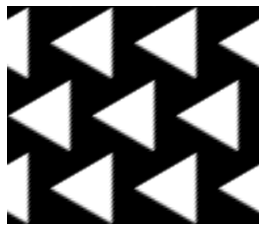

In [114]:
md = mpb.MPBData(rectify=True, periods=3, resolution=64)
eps = ms.get_epsilon()
converted_eps = md.convert(eps)
converted_eps.shape

plt.imshow(converted_eps.T, interpolation='spline36', cmap="binary")
plt.axis('off')
plt.show()

In [115]:
#import csv
#with open('epsilon_distribution.csv', 'wt') as f:
#    writer = csv.writer(f)
#    writer.writerows(converted_eps)

In [116]:
tm_freqs.max()

0.5598955588747815

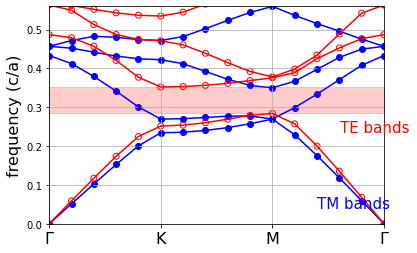

In [117]:
fig, ax = plt.subplots()

x = range(len(tm_freqs))

# Plot bands
# Scatter plot for multiple y values, see https://stackoverflow.com/a/34280815/2261298
for xz, tmz, tez in zip(x, tm_freqs, te_freqs):
    ax.scatter([xz]*len(tmz), tmz, color='blue')
    ax.scatter([xz]*len(tez), tez, color='red', facecolors='none')
ax.plot(tm_freqs, color='blue')
ax.plot(te_freqs, color='red')
ax.set_ylim([tm_freqs.min(), tm_freqs.max()])
ax.set_xlim([x[0], x[-1]])

# Plot gaps
for gap in tm_gaps:
    if gap[0] > 1:
        ax.fill_between(x, gap[1], gap[2], color='blue', alpha=0.2)

for gap in te_gaps:
    if gap[0] > 1:
        ax.fill_between(x, gap[1], gap[2], color='red', alpha=0.2)


# Plot labels
ax.text(12, 0.04, 'TM bands', color='blue', size=15)
ax.text(13.05, 0.235, 'TE bands', color='red', size=15)

points_in_between = (len(tm_freqs) - 4) / 3
tick_locs = [i*points_in_between+i for i in range(4)]
tick_labs = ['Γ', 'K', 'M', 'Γ']
ax.set_xticks(tick_locs)
ax.set_xticklabels(tick_labs, size=16)
ax.set_ylabel('frequency (c/a)', size=16)
ax.grid(True)

plt.show()

Initializing eigensolver data
Computing 4 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 4 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (0.5, 0.866025, 0)
     (0.5, -0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, 0.57735, -0)
     (1, -0.57735, 0)
     (-0, 0, 1)
Geometric objects:
     block, center = (0,0,0)
          size (1e+20,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     prism, center = (0,0,0)
          height 50, axis (0,0,1), sidewall angle: 0 radians, 3 vertices:
          (0.490748,0.490748,-25)
          (-0.490748,0,-25)
          (0,-0.490748,-25)
Geometric object tree has depth 3 and 45 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
16 k-points
  Vector3<0.0, 0.0, 0.0>
  Vector3<0.1, 0.0, 0.0>
  Vector3<0.2, 0.0, 0.0>
  Vector3<0.300000000

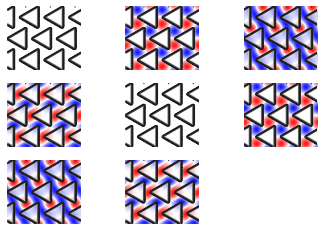

In [123]:
hfields = []

def get_hfields(ms, band):
    hfields.append(ms.get_hfield(band, bloch_phase=True))

ms.run_te(mpb.output_at_kpoint(mp.Vector3(), mpb.fix_hfield_phase,
          get_hfields))

# Create an MPBData instance to transform the hfields
md = mpb.MPBData(rectify=True, resolution=64, periods=3)

converted = []
for f in hfields:
    # Get just the z component of the hfields
    f = f[..., 0, 2]
    converted.append(md.convert(f))

for i, f in enumerate(converted):
    plt.subplot(331 + i)
    plt.contour(converted_eps.T, cmap='binary')
    plt.imshow(np.real(f).T, interpolation='spline36', cmap='bwr', alpha=0.9)
    plt.axis('off')

plt.show()

In [119]:
efields 

[MPBArray([[[[ 2.15318879e-03+1.70313512e-03j,
               9.05527333e-01+9.78473952e-02j,
               0.00000000e+00+0.00000000e+00j]],
 
            [[ 1.40975566e-01-2.80119280e-02j,
               6.49822721e-01+4.14450457e-02j,
               0.00000000e+00+0.00000000e+00j]],
 
            [[ 1.19273390e-01-5.64944898e-02j,
               5.97962045e-01+6.12433351e-02j,
               0.00000000e+00+0.00000000e+00j]],
 
            ...,
 
            [[ 2.68362783e-02-2.42821912e-01j,
              -2.27377460e-01+3.62769203e-01j,
              -0.00000000e+00+0.00000000e+00j]],
 
            [[ 1.04799529e-01-2.76312578e-01j,
              -2.42351366e-01+3.59096155e-01j,
              -0.00000000e+00+0.00000000e+00j]],
 
            [[ 1.35374867e-01-2.53583161e-01j,
              -4.06415040e-01+6.06617969e-01j,
              -0.00000000e+00+0.00000000e+00j]]],
 
 
           [[[-1.43247466e-01+2.53123129e-02j,
               6.62066407e-01+4.34349076e-02j,
              

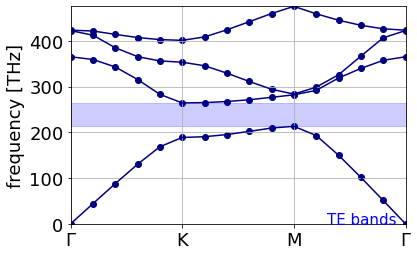

In [120]:
#THz表示
a = 400
c_const = 299792458

fontsize = 18
te_freqs_THz = np.array(te_freqs) * c_const/(a*10**3)
te_gaps_THz = np.array(te_gaps) * c_const/(a*10**3)
#print(te_freqs_THz)

fig, ax = plt.subplots()

x = range(len(te_freqs))

for xz, tez in zip(x, te_freqs_THz):
    ax.scatter([xz]*len(tez), tez, color='navy')

ax.plot(te_freqs_THz, color='navy')
ax.set_ylim([te_freqs_THz.min(), te_freqs_THz.max()])
ax.set_xlim([x[0], x[-1]])

for gap in te_gaps_THz:
    if gap[0] > 1:
        ax.fill_between(x, gap[1], gap[2], color='blue', alpha=0.2)

ax.text(11.5, 0, 'TE bands', color='blue', size=15)

points_in_between = (len(te_freqs) - 4) / 3
tick_locs = [i*points_in_between+i for i in range(4)]
tick_labs = ['Γ', 'K', 'M', 'Γ']
ax.set_xticks(tick_locs)
ax.set_xticklabels(tick_labs, size=fontsize)
ax.set_ylabel('frequency [THz]', size=fontsize)
plt.tick_params(labelsize=fontsize)
ax.grid(True)

plt.show()